### Install

In [247]:
#pip install ucimlrepo

### Imports

In [248]:
# Imports
from ucimlrepo import fetch_ucirepo
import pandas as pd
import psycopg2
from collections import defaultdict
from scipy import stats as kl
from decimal import Decimal
import numpy as np
from scipy.stats import entropy, wasserstein_distance
from itertools import product
import matplotlib.pyplot as plt
from itertools import product


In [249]:
connection = psycopg2.connect(database="Project645", user="vaishnavishah", password="10jan2001", host="localhost", port=5432)
#connection = psycopg2.connect(database="Project645", user="postgres", password="Rajada1234@", host="localhost", port=5433)
#connection = psycopg2.connect(database="seedb", user="postgres", password="nineten910", host="localhost", port=5432)
cursor = connection.cursor()


In [250]:
# checking execution
query = "select workclass from married limit 5;"

cursor.execute(query)
record = cursor.fetchall()
print(record)

[('Self-emp-not-inc',), ('Private',), ('Private',), ('Private',), ('Private',)]


In [251]:
aggregation_functions = ['avg', 'sum', 'max', 'min', 'count']
group_by_columns = [
    'workclass',
    'education',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native_country',
    'income'
]
measure_columns = [
    'age',
    'fnlwgt',
    'education_num',
    'capital_gain',
    'capital_loss',
    'hours_per_week'
]

In [252]:
# FORMULAS 

min_fl = np.finfo(float).eps
def kl_distance(target, reference):
    # print('Target ',target)
    # print('Ref ',reference)
    target = dict(target)
    reference = dict(reference)

    t = list()
    r = list()

    # we need this because this ensures that there are the same number of categories in each distribution
    for key in set().union(target.keys(), reference.keys()):
        t_val = float(target.get(key, 0))
        r_val = float(reference.get(key, 0))
        t.append(t_val)
        r.append(r_val)


    # normalize to create a probability distribution
    t = np.asarray(t) / (np.sum(t) or 1.0)
    r = np.asarray(r) / (np.sum(r) or 1.0)
    t = [max(x, min_fl) for x in t]
    r = [max(x, min_fl) for x in r]


    return entropy(t, r)

def hoeffding_serfling_interval(phase, num_phases, delta):
    phase = float(phase)
    num_phases = float(phase)
    numerator = (1 - ((phase - 1) / num_phases)) * (2 * np.log(np.log(phase)) + np.log((np.pi * np.pi) / (3 * delta)))
    epsilon_m = np.sqrt(numerator / (2 * phase))
    return epsilon_m

In [253]:
# age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country

In [254]:
def calculate_top_k(cur, views_ls, top_k=5, verbose=False):
    results = list()
    query = "select {group}, {func}({m_col}) from {table} {where} group by {group};"
    for group, views in views_ls.items():
        for view in views:
            _, func, m_col = view
            target_query = query.format(group=group,
                                        func=func,
                                        m_col=m_col,
                                        table='married',
                                        where=""
                                        )

            cur.execute(target_query)
            target_results = cur.fetchall()

            reference_query = query.format(group=group,
                                           func=func,
                                           m_col=m_col,
                                           table='unmarried',
                                           where=""
                                           )
            cur.execute(reference_query)
            reference_results = cur.fetchall()
            #print('target ', target_query)
            #print('ref: ', reference_query)
            tmp_query = """
            SELECT COALESCE(t.{group}, r.{group}) AS {group},
                COALESCE(t.target_{func}_{m_col}, 0) AS target_{func}_{m_col},
                COALESCE(r.reference_{func}_{m_col}, 0) AS reference_{func}_{m_col},
                r.table_ref,
                t.table_ref
            FROM (
                -- Target results
                SELECT {group}, {func}({m_col}) AS target_{func}_{m_col}, 'married' AS table_ref
                FROM married
                GROUP BY {group}
            ) AS t
            INNER JOIN (
                -- Reference results
                SELECT {group}, {func}({m_col}) AS reference_{func}_{m_col}, 'unmarried' AS table_ref
                FROM {table_reference}
                GROUP BY {group}
            ) AS r ON t.{group} = r.{group};
            """.format(
                group=group,
                func=func,
                m_col=m_col,
                where_target='',  
                table_reference='unmarried',
            )
            #print('combiend ', tmp_query)
            cur.execute(tmp_query)
            combined_results = cur.fetchall()
            print(combined_results)
            # target_results = [(group, measures) for group, measures, table_ref in combined_results if table_ref == 'married']
            # reference_results = [(group, measures) for group, measures, table_ref in combined_results if table_ref == 'unmarried']

            # print('target ',target_results)
            # print('ref ',reference_results)
            # dist = kl_distance(target_results, reference_results)
            # print(dist)
            # results.append((view, dist))
            # print(results)
            # if verbose:
            #     print ("{}, {}, {}".format(group, func, m_col), dist)
            break
    return list(reversed(sorted(results, key=lambda x: x[1])))[:top_k]

In [255]:
def naive_search(cur, views_ls, top_k=5, verbose=False):

    grouped_views = defaultdict(list)

    for view in views_ls:
        grouper = view[0]
        grouped_views[grouper].append(view)

    
    return calculate_top_k(cur, grouped_views, top_k, verbose)


In [256]:
views_ls = []
for a in group_by_columns:
    for f in aggregation_functions:
        for m in measure_columns:
            views_ls.append((a,f,m))
naive_search(cursor, views_ls, 5)

[('Without-pay', Decimal('57.2142857142857143'), Decimal('21.1666666666666667'), 'unmarried', 'married'), ('Self-emp-not-inc', Decimal('47.3603428126217374'), Decimal('38.5029411764705882'), 'unmarried', 'married'), ('State-gov', Decimal('43.4854910714285714'), Decimal('34.8117021276595745'), 'unmarried', 'married'), ('Private', Decimal('41.3204585778626996'), Decimal('31.7769180013196569'), 'unmarried', 'married'), ('Self-emp-inc', Decimal('47.6477272727272727'), Decimal('37.4571428571428571'), 'unmarried', 'married'), ('Federal-gov', Decimal('44.8841379310344828'), Decimal('38.4285714285714286'), 'unmarried', 'married'), ('Local-gov', Decimal('44.0077369439071567'), Decimal('36.9664889565879665'), 'unmarried', 'married')]
[('Assoc-voc', Decimal('40.6555555555555556'), Decimal('34.4994192799070848'), 'unmarried', 'married'), ('10th', Decimal('45.1025641025641026'), Decimal('29.5355932203389831'), 'unmarried', 'married'), ('HS-grad', Decimal('42.3191640602786466'), Decimal('33.45242747

[('Sales', Decimal('43.5495207667731629'), Decimal('30.1357361963190184'), 'unmarried', 'married'), ('Machine-op-inspct', Decimal('40.4402985074626866'), Decimal('33.1558139534883721'), 'unmarried', 'married'), ('Farming-fishing', Decimal('46.1893687707641196'), Decimal('31.2732558139534884'), 'unmarried', 'married'), ('Craft-repair', Decimal('41.5744403956272775'), Decimal('33.2945696721311475'), 'unmarried', 'married'), ('Exec-managerial', Decimal('44.5902004454342984'), Decimal('37.1974492205951819'), 'unmarried', 'married'), ('Handlers-cleaners', Decimal('39.2685560053981107'), Decimal('27.8627773212818406'), 'unmarried', 'married'), ('Prof-specialty', Decimal('43.4665398033618776'), Decimal('36.0197444831591173'), 'unmarried', 'married'), ('Tech-support', Decimal('40.9884678747940692'), Decimal('33.1054794520547945'), 'unmarried', 'married'), ('Transport-moving', Decimal('43.6608695652173913'), Decimal('33.9366391184573003'), 'unmarried', 'married'), ('Adm-clerical', Decimal('41.5

[]

In [ ]:
def sharing_based_search(cur, views_ls, top_k=5, verbose=False):

    grouped_views = defaultdict(list)

    for view in views_ls:
        grouper = view[0]
        grouped_views[grouper].append(view)

    return calculate_top_k(cur, grouped_views, top_k, verbose)

In [98]:
def pruning_based_search(cur, views, top_k=5, verbose=False):
    mean_utils = {}

    for view, utility in naive_search(cur, views, top_k=None):
        mean_utils[view] = (mean_utils.get(view, 0) + utility) / 2

    sorted_utils = sorted(mean_utils.values())
    max_utility = sorted_utils[-1]
    kth_utility = sorted_utils[-top_k] / max_utility

    for i in range(len(views)):
        if i == 0:
            if verbose:
                print("No pruning on the first iteration due to NaN epsilon.")
            continue

        epsilon = hoeffding_serfling_interval(i + 1, len(views), 0.1) 

        not_pruned_views = [v for v in views if (mean_utils[v] / max_utility + epsilon) >= (kth_utility - epsilon)]
        if verbose:
            print("Iteration %d: Pruned %d views." % (i, len(views) - len(not_pruned_views)))

        views = not_pruned_views[:]

    if verbose:
        print("Finished with %d views." % len(views))

    return sharing_based_search(cur, views, top_k, verbose)


In [99]:
views_ls = []
for a in group_by_columns:
    for f in aggregation_functions:
        for m in measure_columns:
            views_ls.append((a,f,m))


top_5_prun = pruning_based_search(cursor, views_ls,verbose=True)

No pruning on the first iteration due to NaN epsilon.
Iteration 1: Pruned 0 views.
Iteration 2: Pruned 203 views.
Iteration 3: Pruned 8 views.
Iteration 4: Pruned 12 views.
Iteration 5: Pruned 1 views.
Iteration 6: Pruned 2 views.
Iteration 7: Pruned 0 views.
Iteration 8: Pruned 1 views.
Iteration 9: Pruned 0 views.
Iteration 10: Pruned 0 views.
Iteration 11: Pruned 0 views.
Iteration 12: Pruned 0 views.
Iteration 13: Pruned 0 views.
Iteration 14: Pruned 0 views.
Iteration 15: Pruned 0 views.
Iteration 16: Pruned 0 views.
Iteration 17: Pruned 0 views.
Iteration 18: Pruned 0 views.
Iteration 19: Pruned 0 views.
Iteration 20: Pruned 0 views.
Iteration 21: Pruned 0 views.
Iteration 22: Pruned 0 views.
Iteration 23: Pruned 0 views.
Iteration 24: Pruned 0 views.
Iteration 25: Pruned 0 views.
Iteration 26: Pruned 0 views.
Iteration 27: Pruned 0 views.
Iteration 28: Pruned 0 views.
Iteration 29: Pruned 0 views.
Iteration 30: Pruned 0 views.
Iteration 31: Pruned 0 views.
Iteration 32: Pruned 0

In [100]:
top_5_shar = sharing_based_search(cursor, views_ls, verbose=False)

In [101]:
top_5_shar

[(('relationship', 'sum', 'capital_gain'), 35.15956612486812),
 (('relationship', 'sum', 'capital_loss'), 34.87747673512298),
 (('relationship', 'sum', 'age'), 34.296064194395626),
 (('relationship', 'sum', 'hours_per_week'), 34.276281101060064),
 (('relationship', 'sum', 'education_num'), 34.264130484222676)]

In [102]:
top_5_prun

[(('relationship', 'sum', 'capital_gain'), 35.15956612486812),
 (('relationship', 'sum', 'capital_loss'), 34.87747673512298),
 (('relationship', 'sum', 'age'), 34.296064194395626),
 (('relationship', 'sum', 'hours_per_week'), 34.276281101060064),
 (('relationship', 'sum', 'education_num'), 34.264130484222676)]

In [103]:
def visualise(view, names, utility):
    width=0.35
    index = np.arange(len(names))

    fig, ax = plt.subplots(figsize=(10, 6)) 
    
    light_pink = '#FFB6C1'  
    pastel_blue = '#AEC6CF' 

    t_bar = ax.bar(index, t, width, color=light_pink)
    r_bar = ax.bar(index + width, r, width, color=pastel_blue)
    
    ax.set_title("{f}({m}) Grouped by {g} (Measure = {measure}, Utility = {util})".format(f=view[1],
    m=view[2],
    g=view[0],
    measure="KLD",
    util=utility),
    fontsize=16, color='navy')  
    ax.set_ylabel("{f}({m})".format(f=view[1], m=view[2]), fontsize=14, color='purple')  
    ax.set_xlabel("Categories of {g}".format(g=view[0]), fontsize=14, color='green') 
    ax.set_xticks(index + width / 2)
    ax.set_xticklabels(names, fontsize=12, color='gray', rotation=45)  

    ax.legend((t_bar[0], r_bar[0]), ('Married', 'Unmarried'), loc='upper right', fontsize=12)

    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray')  

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()  
    plt.show()

No pruning on the first iteration due to NaN epsilon.
Iteration 1: Pruned 0 views.
Iteration 2: Pruned 203 views.
Iteration 3: Pruned 8 views.
Iteration 4: Pruned 12 views.
Iteration 5: Pruned 1 views.
Iteration 6: Pruned 2 views.
Iteration 7: Pruned 0 views.
Iteration 8: Pruned 1 views.
Iteration 9: Pruned 0 views.
Iteration 10: Pruned 0 views.
Iteration 11: Pruned 0 views.
Iteration 12: Pruned 0 views.
Iteration 13: Pruned 0 views.
Iteration 14: Pruned 0 views.
Iteration 15: Pruned 0 views.
Iteration 16: Pruned 0 views.
Iteration 17: Pruned 0 views.
Iteration 18: Pruned 0 views.
Iteration 19: Pruned 0 views.
Iteration 20: Pruned 0 views.
Iteration 21: Pruned 0 views.
Iteration 22: Pruned 0 views.
Iteration 23: Pruned 0 views.
Iteration 24: Pruned 0 views.
Iteration 25: Pruned 0 views.
Iteration 26: Pruned 0 views.
Iteration 27: Pruned 0 views.
Iteration 28: Pruned 0 views.
Iteration 29: Pruned 0 views.
Iteration 30: Pruned 0 views.
Iteration 31: Pruned 0 views.
Iteration 32: Pruned 0

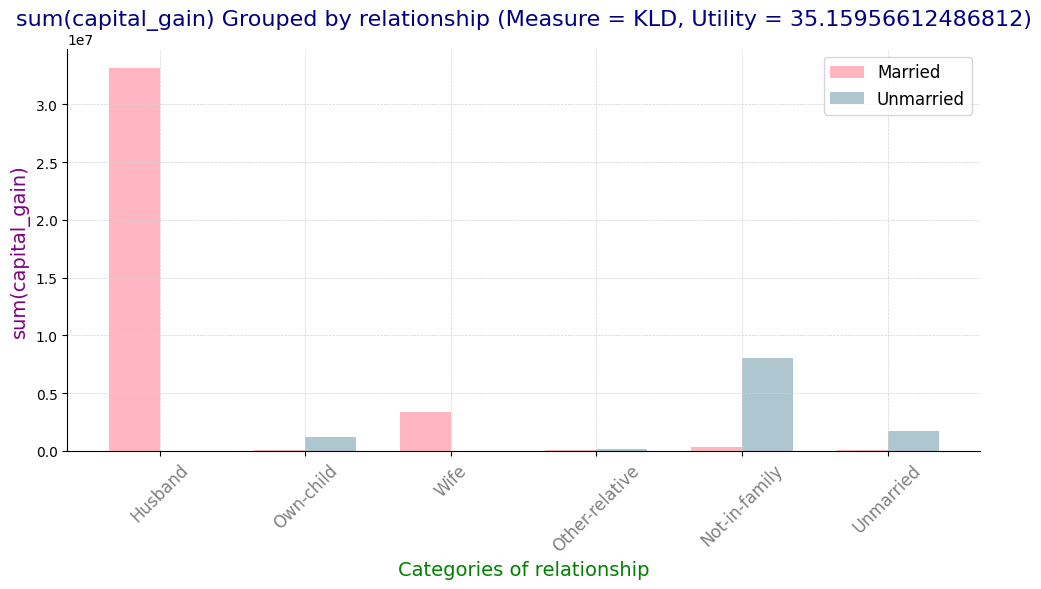

('relationship', 'sum', 'capital_loss') 34.87747673512298


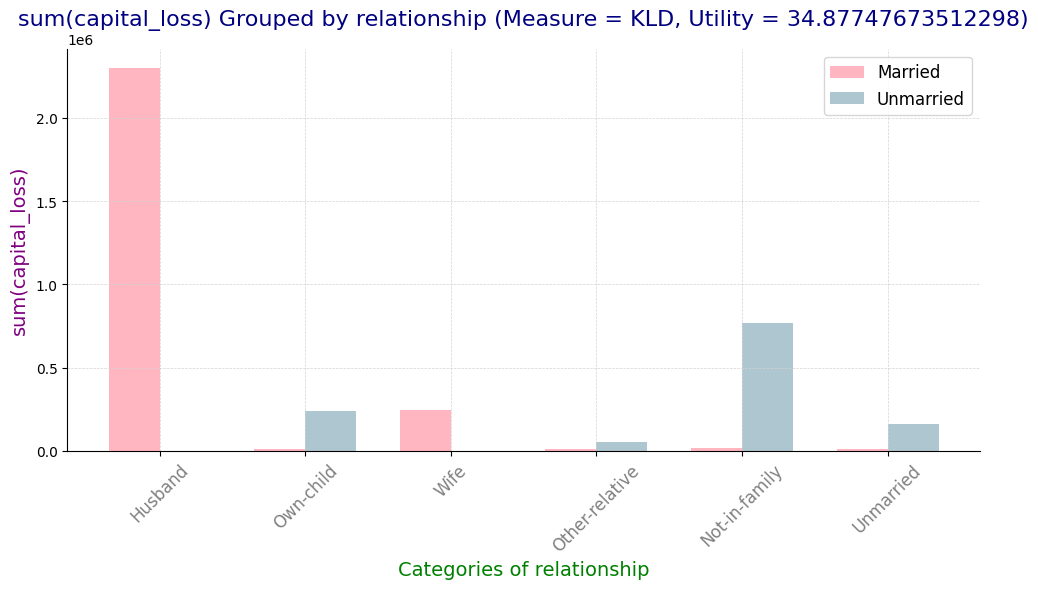

('relationship', 'sum', 'age') 34.296064194395626


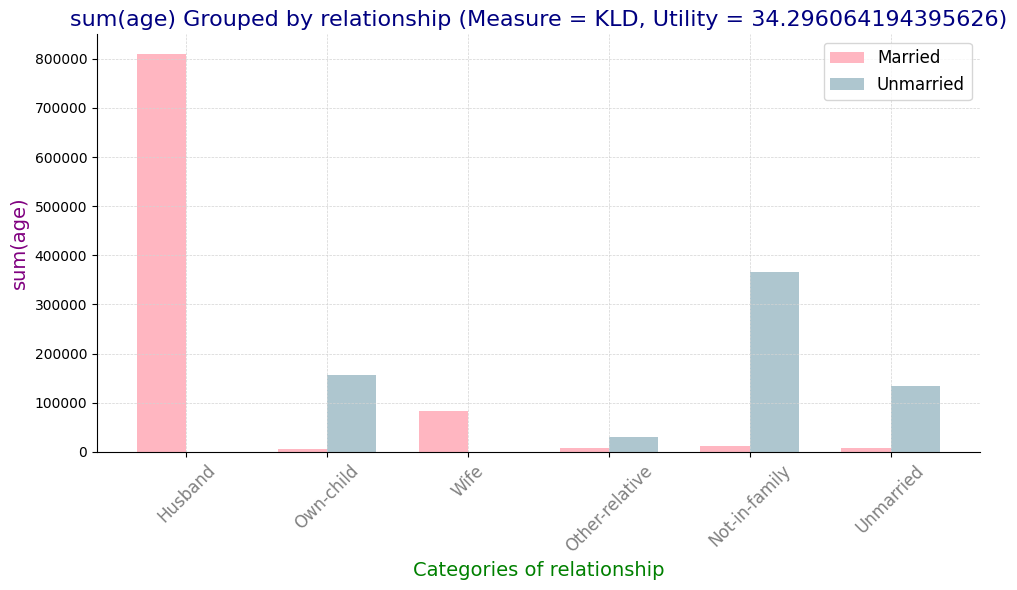

('relationship', 'sum', 'hours_per_week') 34.276281101060064


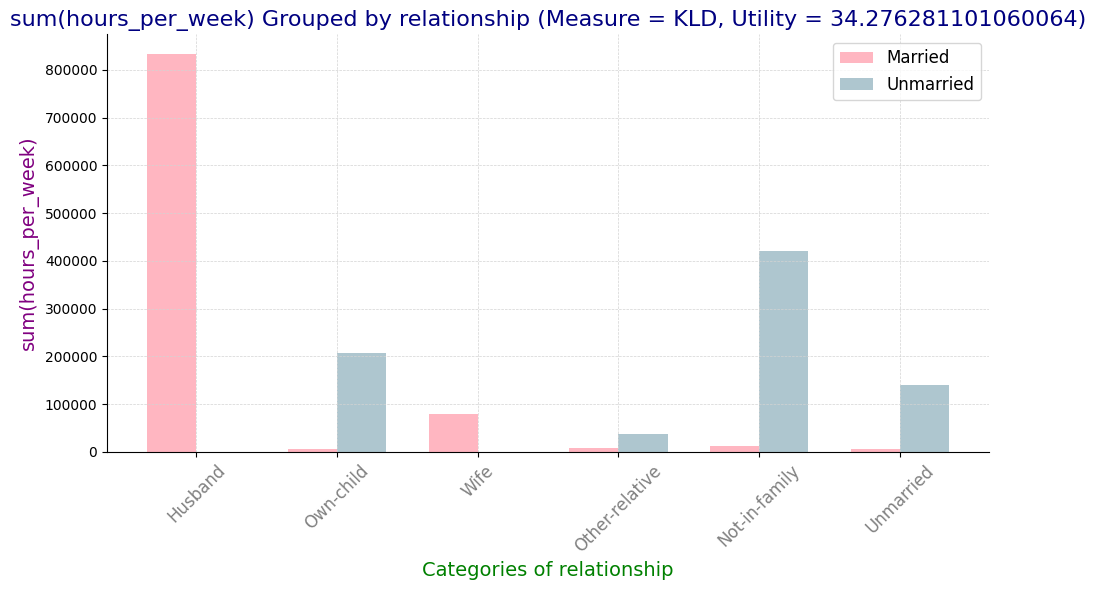

('relationship', 'sum', 'education_num') 34.264130484222676


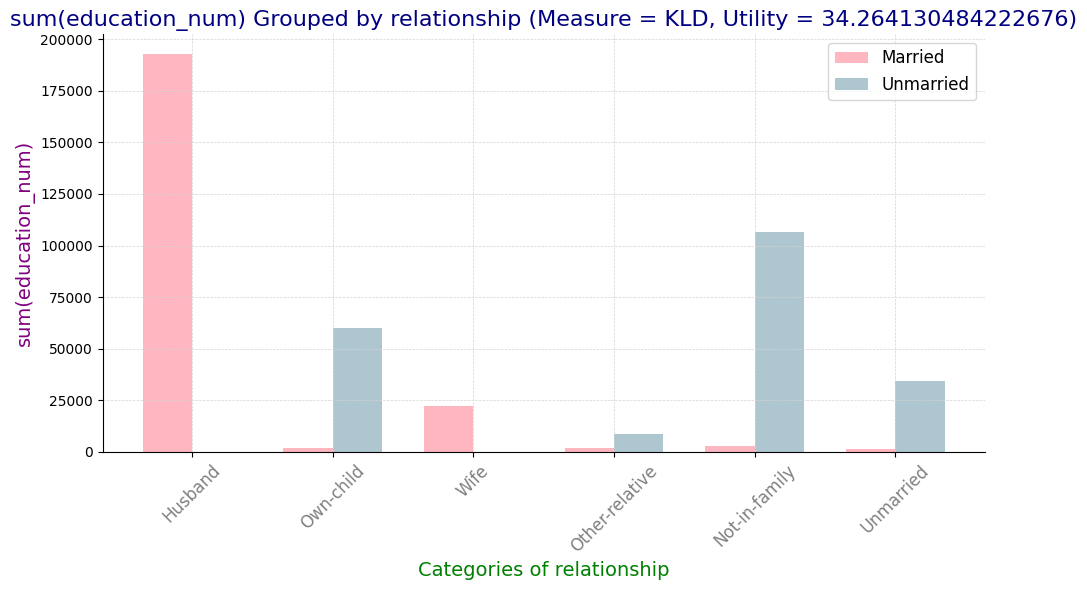

In [104]:
if __name__ == "__main__":

   
    views_ls = []
    for a in group_by_columns:
        for f in aggregation_functions:
            for m in measure_columns:
                views_ls.append((a,f,m))


    for i in range(1):
        top_5 = pruning_based_search(cursor, views_ls,verbose=True)

        #top_5 = sharing_based_search(cursor, views_ls, verbose=False)

    for view, utility in top_5:
        print (view, utility)

        cursor.execute("select {g}, {f}({m}) from married group by {g};".format(g=view[0], f=view[1], m=view[2]))
        target = dict(cursor.fetchall())

        cursor.execute("select {g}, {f}({m}) from unmarried group by {g};".format(g=view[0], f=view[1], m=view[2]))
        reference = dict(cursor.fetchall())

        t = list()
        r = list()
        names = list()

        for key in set().union(target.keys(), reference.keys()):
            names.append(key)
            t_val = float(target.get(key, 0))
            r_val = float(reference.get(key, 0))
            t.append(t_val)
            r.append(r_val)
        
        visualise(view, names, utility)

    connection.commit() 

In [105]:
cursor.close()
connection.close()

In [106]:
# age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country